In [1]:
import lib ## my module set

import os
import torch
import torchvision
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
import random

from tqdm import tqdm
from sklearn.manifold import TSNE
from IPython.display import display
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
from torchvision.models import efficientnet_b0, mobilenet_v2
from sklearn.metrics import silhouette_score, silhouette_samples



%matplotlib inline

os.environ["CUDA_VISIBLE_DEVICES"] = "5"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)  # 멀티 GPU를 사용하는 경우
np.random.seed(42)
random.seed(42)
# torch.backends.cudnn.deterministic = True ## 속도가 느려질 수 있음
# torch.backends.cudnn.benchmark = False

plt.rcParams['font.family'] = 'Liberation Serif'

In [2]:
train = pd.read_csv("./train_v2.csv")
valid = pd.read_csv("./valid_v2.csv")
test = pd.read_csv("./test_v2.csv")

In [3]:
train['label'].value_counts()

label
2    404
3    378
1    229
0    162
Name: count, dtype: int64

In [4]:
train_dataset = lib.CustomDataset(train)
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True, pin_memory= True, num_workers = 8) 

valid_dataset = lib.CustomDataset(valid, train_test= False)
valid_loader = DataLoader(valid_dataset, batch_size = 32, shuffle = True, pin_memory= True, num_workers = 8)

test_dataset = lib.CustomDataset(test, train_test = False)
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle = False, pin_memory= True, num_workers = 8)

In [5]:
class MyNeural(nn.Module):
    def __init__(self, model, freeze_ratio = 0.7):
        super(MyNeural, self).__init__()

        self.mother = lib.freeze_layers_by_percentage(model, freeze_ratio)

        self.mother.classifier = nn.Sequential(
        nn.Dropout(p=0.2, inplace = False),
        nn.Linear(in_features = 1280, out_features = 256, bias = True),
        )
        
        self.classifier = nn.Sequential(
            nn.SiLU(inplace = True),
            nn.Dropout(0.2, inplace = False),
            nn.Linear(256, 64, bias = True),
            nn.SiLU(inplace = True),
            nn.Dropout(0.2, inplace = False),
            nn.Linear(64, 4, bias = True)
        )

    
    def forward(self, x):
        embedding = self.mother(x)
         
        x = self.classifier(embedding)

        return (embedding, x)

Mobilenet = mobilenet_v2(weights = 'IMAGENET1K_V1')

Mobilenet = MyNeural(Mobilenet, freeze_ratio = 0.6).to(device)

Features 블록 총 19개 중 11개 고정
고정할 블록들: ['features.0', 'features.1', 'features.2', 'features.3', 'features.4', 'features.5', 'features.6', 'features.7', 'features.8', 'features.9', 'features.10']
고정됨: features.0.0.weight
고정됨: features.0.1.weight
고정됨: features.0.1.bias
고정됨: features.1.conv.0.0.weight
고정됨: features.1.conv.0.1.weight
고정됨: features.1.conv.0.1.bias
고정됨: features.1.conv.1.weight
고정됨: features.1.conv.2.weight
고정됨: features.1.conv.2.bias
고정됨: features.2.conv.0.0.weight
고정됨: features.2.conv.0.1.weight
고정됨: features.2.conv.0.1.bias
고정됨: features.2.conv.1.0.weight
고정됨: features.2.conv.1.1.weight
고정됨: features.2.conv.1.1.bias
고정됨: features.2.conv.2.weight
고정됨: features.2.conv.3.weight
고정됨: features.2.conv.3.bias
고정됨: features.3.conv.0.0.weight
고정됨: features.3.conv.0.1.weight
고정됨: features.3.conv.0.1.bias
고정됨: features.3.conv.1.0.weight
고정됨: features.3.conv.1.1.weight
고정됨: features.3.conv.1.1.bias
고정됨: features.3.conv.2.weight
고정됨: features.3.conv.3.weight
고정됨: features.3.conv.3.bias
고

In [6]:
## 학습을 위한 최적화, 함수, Miner 설정

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(Mobilenet.parameters(), lr=1e-4)

# training, Deep Metric Learning

patience = 0
Epochs = 100
best_loss = 999999.0

for epoch in range(Epochs):
    train_loss, train_correct = lib.classifier_train(train_loader, Mobilenet, loss_fn, optimizer)
    valid_loss, valid_correct = lib.classifier_validation(valid_loader, Mobilenet, loss_fn)
    
    print(f"Epoch {epoch} : Train Loss = {train_loss:.4f}, Train Correct: {train_correct} Valid Loss = {valid_loss:.4f}, Valid Correct = {valid_correct}")
    
    if best_loss > valid_loss:
        best_loss = valid_loss
        patience = 0
        print(f'Epoch {epoch} Model saved ')
        torch.save({
                'model' : Mobilenet.state_dict(),
                'optimizer' : optimizer.state_dict()}, '../model_weight/Classifier/Mobilenet_freeze.pth') #'../model_weight/Classifier/Mobilenet.pth' 성능 낮게 나오는거
    else:
        patience += 1
        if patience == 10:
            print('early stopping')
            break
        

Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  2.80it/s]


Epoch 0 : Train Loss = 1.1604, Train Correct: 0.5140664961636828 Valid Loss = 0.8516, Valid Correct = 0.6130952380952381
Epoch 0 Model saved 


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.71it/s]


Epoch 1 : Train Loss = 0.7627, Train Correct: 0.6555839727195226 Valid Loss = 0.6869, Valid Correct = 0.7321428571428571
Epoch 1 Model saved 


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.58it/s]


Epoch 2 : Train Loss = 0.6006, Train Correct: 0.7587382779198636 Valid Loss = 0.5354, Valid Correct = 0.7827380952380952
Epoch 2 Model saved 


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  2.76it/s]


Epoch 3 : Train Loss = 0.5154, Train Correct: 0.7757885763000852 Valid Loss = 0.5009, Valid Correct = 0.7708333333333334
Epoch 3 Model saved 


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.66it/s]


Epoch 4 : Train Loss = 0.4340, Train Correct: 0.8363171355498721 Valid Loss = 0.4039, Valid Correct = 0.8303571428571429
Epoch 4 Model saved 


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  2.84it/s]


Epoch 5 : Train Loss = 0.3884, Train Correct: 0.8388746803069054 Valid Loss = 0.3400, Valid Correct = 0.8511904761904762
Epoch 5 Model saved 


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  2.84it/s]


Epoch 6 : Train Loss = 0.3716, Train Correct: 0.8431372549019608 Valid Loss = 0.3325, Valid Correct = 0.8630952380952381
Epoch 6 Model saved 


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.05it/s]


Epoch 7 : Train Loss = 0.3601, Train Correct: 0.8644501278772379 Valid Loss = 0.3488, Valid Correct = 0.8601190476190477


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  2.95it/s]


Epoch 8 : Train Loss = 0.3710, Train Correct: 0.8473998294970162 Valid Loss = 0.3214, Valid Correct = 0.8571428571428571
Epoch 8 Model saved 


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  2.82it/s]


Epoch 9 : Train Loss = 0.2899, Train Correct: 0.8891730605285593 Valid Loss = 0.2808, Valid Correct = 0.8839285714285714
Epoch 9 Model saved 


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  2.83it/s]


Epoch 10 : Train Loss = 0.2923, Train Correct: 0.8849104859335039 Valid Loss = 0.3158, Valid Correct = 0.8690476190476191


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.63it/s]


Epoch 11 : Train Loss = 0.2789, Train Correct: 0.887468030690537 Valid Loss = 0.3684, Valid Correct = 0.8601190476190477


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  2.79it/s]


Epoch 12 : Train Loss = 0.2510, Train Correct: 0.9130434782608695 Valid Loss = 0.3274, Valid Correct = 0.8630952380952381


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  2.83it/s]


Epoch 13 : Train Loss = 0.2977, Train Correct: 0.8951406649616368 Valid Loss = 0.3323, Valid Correct = 0.8482142857142857


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.09it/s]


Epoch 14 : Train Loss = 0.2516, Train Correct: 0.9011082693947144 Valid Loss = 0.4135, Valid Correct = 0.8273809523809523


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  2.94it/s]


Epoch 15 : Train Loss = 0.2359, Train Correct: 0.907928388746803 Valid Loss = 0.3141, Valid Correct = 0.875


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.71it/s]


Epoch 16 : Train Loss = 0.1875, Train Correct: 0.9343563512361467 Valid Loss = 0.3123, Valid Correct = 0.8869047619047619


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.71it/s]


Epoch 17 : Train Loss = 0.2080, Train Correct: 0.9215686274509803 Valid Loss = 0.3482, Valid Correct = 0.8630952380952381


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  2.75it/s]


Epoch 18 : Train Loss = 0.1914, Train Correct: 0.9335038363171355 Valid Loss = 0.4125, Valid Correct = 0.8571428571428571


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  2.84it/s]

Epoch 19 : Train Loss = 0.1789, Train Correct: 0.9343563512361467 Valid Loss = 0.3608, Valid Correct = 0.8779761904761905
early stopping


## 분류 모델 결과 시각화

In [6]:
total_loader_v = DataLoader(valid_dataset, batch_size = 1, shuffle = False, pin_memory= True, num_workers = 8)
total_loader_t = DataLoader(test_dataset, batch_size = 1, shuffle = False, pin_memory= True, num_workers = 8)


In [7]:
checkpoint = torch.load('../model_weight/Classifier/Mobilenet_well.pth')

Mobilenet.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [8]:
test_loss, correction = lib.classifier_validation(total_loader_t, Mobilenet, loss_fn)
print(correction)

NameError: name 'loss_fn' is not defined

In [13]:
pred_acc = []
real_acc = []

embeddings = []

with torch.no_grad():
    Mobilenet.eval()
    for data, label in tqdm(total_loader_v, desc = 'total_loader_v'):
        data = data.to(device)
        embedding, pred = Mobilenet(data)
        
        embeddings.append(embedding)
        
        pred_acc.append(pred.argmax(1).item())
        real_acc.append(label.item())

embeddings = torch.stack(embeddings, dim = 1).squeeze()

    

total_loader_v: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 336/336 [00:03<00:00, 96.37it/s]


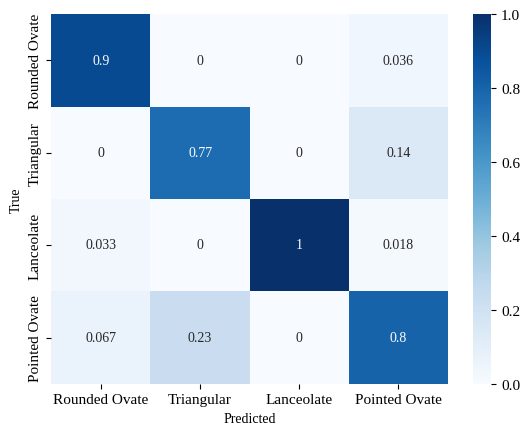

In [10]:
plt.rc('xtick', labelsize=11)  # x축 눈금 폰트 크기 
plt.rc('ytick', labelsize=11) 

cm = confusion_matrix(real_acc, pred_acc, normalize = 'pred')
cm = pd.DataFrame(cm , columns = ['Rounded Ovate', 'Triangular', 'Lanceolate', 'Pointed Ovate'],index = ['Rounded Ovate', 'Triangular', 'Lanceolate', 'Pointed Ovate'])
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [213]:
from sklearn.metrics import f1_score
f1_weighted = f1_score(real_acc, pred_acc, average='macro')
f1_weighted

0.8660347979435622

0.5043947696685791

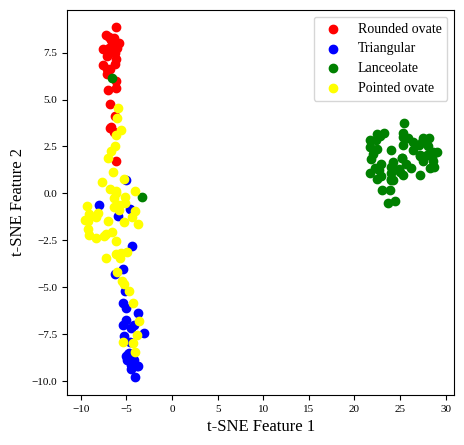

In [11]:

plt.figure(figsize=(5, 5))

plt.rc('xtick', labelsize=8)  # x축 눈금 폰트 크기 
plt.rc('ytick', labelsize=8)  # y축 눈금 폰트 크기
plt.rc('axes', labelsize=12)
plt.rc('legend', fontsize=10) 


tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(embeddings.detach().cpu())

df_tsne = pd.DataFrame(data = X_tsne)
df_tsne['label']= real_acc
df_tsne

plt.scatter(df_tsne[df_tsne['label'] == 0][0], df_tsne[df_tsne['label'] == 0][1], label = 'Rounded ovate',  c= 'red')
plt.scatter(df_tsne[df_tsne['label'] == 1][0], df_tsne[df_tsne['label'] == 1][1], label = 'Triangular', c= 'blue')
plt.scatter(df_tsne[df_tsne['label'] == 2][0], df_tsne[df_tsne['label'] == 2][1], label = 'Lanceolate', c= 'green')
plt.scatter(df_tsne[df_tsne['label'] == 3][0], df_tsne[df_tsne['label'] == 3][1], label = 'Pointed ovate',  c= 'yellow')

plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.legend()

score = silhouette_score(X_tsne, real_acc)
score

In [12]:
score_samples = silhouette_samples(df_tsne[[0, 1]], df_tsne['label'])
df_tsne['sil_coeffi'] = score_samples
df_tsne.groupby('label')['sil_coeffi'].mean()

label
0    0.699889
1    0.336759
2    0.811998
3    0.149367
Name: sil_coeffi, dtype: float32

In [ ]:
label v
0    0.614262
1    0.582419
2    0.759158
3    0.266808


In [ ]:
t

0    0.699889
1    0.336759
2    0.811998
3    0.149367